# Theory for Atomic Fountain Interferometer - Mirror from scratch

$\newcommand{tr}[0]{\operatorname{tr}}
\newcommand{diag}[0]{\operatorname{diag}}
\newcommand{abs}[0]{\operatorname{abs}}
\newcommand{pop}[0]{\operatorname{pop}}
\newcommand{aux}[0]{\text{aux}}
\newcommand{opt}[0]{\text{opt}}
\newcommand{tgt}[0]{\text{tgt}}
\newcommand{init}[0]{\text{init}}
\newcommand{lab}[0]{\text{lab}}
\newcommand{rwa}[0]{\text{rwa}}
\newcommand{bra}[1]{\langle#1\vert}
\newcommand{ket}[1]{\vert#1\rangle}
\newcommand{Bra}[1]{\left\langle#1\right\vert}
\newcommand{Ket}[1]{\left\vert#1\right\rangle}
\newcommand{Braket}[2]{\left\langle #1\vphantom{#2} \mid #2\vphantom{#1}\right\rangle}
\newcommand{op}[1]{\hat{#1}}
\newcommand{Op}[1]{\hat{#1}}
\newcommand{dd}[0]{\,\text{d}}
\newcommand{Liouville}[0]{\mathcal{L}}
\newcommand{DynMap}[0]{\mathcal{E}}
\newcommand{identity}[0]{\mathbf{1}}
\newcommand{Norm}[1]{\lVert#1\rVert}
\newcommand{Abs}[1]{\left\vert#1\right\vert}
\newcommand{avg}[1]{\langle#1\rangle}
\newcommand{Avg}[1]{\left\langle#1\right\rangle}
\newcommand{AbsSq}[1]{\left\vert#1\right\vert^2}
\newcommand{Re}[0]{\operatorname{Re}}
\newcommand{Im}[0]{\operatorname{Im}}$

In [1]:
from functools import partial

In [2]:
import sympy
import numpy as np
import matplotlib
import matplotlib.pylab as plt

In [3]:
%matplotlib inline

In [4]:
sympy.init_printing()

In [5]:
from sympy import Wild, symbols, Function, exp, cos, I, DiracDelta, Abs, oo

In [6]:
from sympy import UnevaluatedExpr as protect

In [7]:
from symbolic_equation import Eq

In [8]:
# local imports
from dirac_tools import normalize_dirac_delta_terms

In [9]:
def incl_range(a, b, step=1):
    """Inclusive range (a, b)"""
    e = 1 if step > 0 else -1
    return range(a, b + e, step)

In [10]:
_w = Wild('w')

In [11]:
defs = {}

In [12]:
def definition(sym):
    return Eq(sym, defs[sym])

In [13]:
def standard_phase_form(expr):
    """Combine exponentials and separate out $i$ and $t$.
    This ensures the standard form $e^{i ω t)$
    """
    return (
        expr
        .powsimp()
        .replace(exp, lambda arg: exp(arg.collect(I)))
        .replace(exp, lambda arg: exp(arg.collect(t)))
    )

## Schrödinger equation in position space

We start out with the time-dependent Schrödinger equation in momentum space for the complex amplitude $a(z, t)$, coupled to $b(z, t)$, using two counter-propagating lasers with wave number $k$, and envelopes $\Omega_1(t)$, $\Omega_2(t)$ and frequency $\omega_1(t)$, $\omega_2(t)$, respectively:

In [14]:
a, b = symbols('a, b', cls=Function)
z, t, p, k = symbols('z, t, p, k', real=True)
ħ, m = symbols('hbar, m', positive=True)
Ω1, Ω2, ω1, ω2 = symbols('Omega_1, Omega_2, omega_1, omega_2', cls=Function, real=True)

In [15]:
TDSE_a_coupled_b = Eq(
    I * ħ * a(z, t).diff(t),
    p**2/(2*m) * a(z, t) - (
        ħ * Ω1(t) * cos(ω1(t) + k * z)
        + ħ * Ω2(t) * cos(ω2(t) - k * z)
    ) * b(t)
)
TDSE_a_coupled_b

I*hbar*Derivative(a(z, t), t) = -(hbar*Omega_1(t)*cos(k*z + omega_1(t)) + hbar*Omega_2(t)*cos(k*z - omega_2(t)))*b(t) + p**2*a(z, t)/(2*m)

The laser frequencies take the following form:

In [16]:
δ0  = symbols('delta_0', real=True)
ϕ1, ϕ2 = symbols("phi_1, phi_2", cls=Function, real=True)
ω0 = symbols('omega_0', positive=True)
defs.update({
    ω1(t): ω0 * t + ϕ1(t),
    ω2(t): ω0 * t + ϕ2(t) + δ0 * t,
})

In [17]:
definition(ω1(t))

omega_1(t) = omega_0*t + phi_1(t)

In [18]:
definition(ω2(t))

omega_2(t) = delta_0*t + omega_0*t + phi_2(t)

We assume the transition to the excited state (amplitude $b(t)$, to be far detuned, with detuning $\Delta$:

In [19]:
Δ  = symbols('Delta', real=True)

We define $\tilde b(z, t) = b(z, t) e^{i \omega_0 t}$, and make the ansatz for the adiabatic elimination of $\tilde b(z, t)$ 

In [20]:
b̃ = symbols('b̃', cls=Function)
defs[b̃(z, t)] = (
    1 / (2 * Δ) * (
        Ω1(t) * exp(-I * (ϕ1(t) + k*z))
        + Ω2(t) * exp(-I * (ϕ2(t) + δ0 * t - k * z))
    ) * a(z, t)
).expand().collect(a(z, t))

In [21]:
definition(b̃(z, t))

b̃(z, t) = (Omega_1(t)*exp(-I*phi_1(t))*exp(-I*k*z)/(2*Delta) + Omega_2(t)*exp(-I*phi_2(t))*exp(-I*delta_0*t)*exp(I*k*z)/(2*Delta))*a(z, t)

We plug this in to the Schrödinger equation for $a(z, t)$ to uncouple it from $b(z,t)$:

In [22]:
TDSE_a_uncoupled = (
    TDSE_a_coupled_b
    .apply_mtd(
        'subs',
        {b(t): defs[b̃(z, t)] * exp(-I * ω0 * t)})
     .apply_mtd('rewrite', exp, cont=False)
     .apply_mtd('expand')
     #.apply(standard_phase_form)
     .apply_mtd('collect', a(z, t))
)
TDSE_a_uncoupled

I*hbar*Derivative(a(z, t), t) = (p**2/(2*m) - hbar*Omega_1(t)**2*exp(I*omega_1(t))*exp(-I*phi_1(t))*exp(-I*omega_0*t)/(4*Delta) - hbar*Omega_1(t)**2*exp(-I*omega_1(t))*exp(-I*phi_1(t))*exp(-2*I*k*z)*exp(-I*omega_0*t)/(4*Delta) - hbar*Omega_1(t)*Omega_2(t)*exp(I*omega_1(t))*exp(-I*phi_2(t))*exp(-I*delta_0*t)*exp(2*I*k*z)*exp(-I*omega_0*t)/(4*Delta) - hbar*Omega_1(t)*Omega_2(t)*exp(I*omega_2(t))*exp(-I*phi_1(t))*exp(-2*I*k*z)*exp(-I*omega_0*t)/(4*Delta) - hbar*Omega_1(t)*Omega_2(t)*exp(-I*omega_2(t))*exp(-I*phi_1(t))*exp(-I*omega_0*t)/(4*Delta) - hbar*Omega_1(t)*Omega_2(t)*exp(-I*omega_1(t))*exp(-I*phi_2(t))*exp(-I*delta_0*t)*exp(-I*omega_0*t)/(4*Delta) - hbar*Omega_2(t)**2*exp(I*omega_2(t))*exp(-I*phi_2(t))*exp(-I*delta_0*t)*exp(-I*omega_0*t)/(4*Delta) - hbar*Omega_2(t)**2*exp(-I*omega_2(t))*exp(-I*phi_2(t))*exp(-I*delta_0*t)*exp(2*I*k*z)*exp(-I*omega_0*t)/(4*Delta))*a(z, t)

We continue by plugging in the explicit form of the laser frequencies:

In [23]:
TDSE_a_uncoupled2 = (
    TDSE_a_uncoupled
    .apply_mtd(
        'subs',
        {
            ω1(t): defs[ω1(t)],
            ω2(t): defs[ω2(t)],
        })
     .apply_mtd('rewrite', exp, cont=False)
     .apply_mtd('expand')
)
TDSE_a_uncoupled2

I*hbar*Derivative(a(z, t), t) = p**2*a(z, t)/(2*m) - hbar*Omega_1(t)**2*a(z, t)/(4*Delta) - hbar*Omega_1(t)**2*a(z, t)*exp(-2*I*phi_1(t))*exp(-2*I*k*z)*exp(-2*I*omega_0*t)/(4*Delta) - hbar*Omega_1(t)*Omega_2(t)*a(z, t)*exp(I*phi_1(t))*exp(-I*phi_2(t))*exp(-I*delta_0*t)*exp(2*I*k*z)/(4*Delta) - hbar*Omega_1(t)*Omega_2(t)*a(z, t)*exp(-I*phi_1(t))*exp(I*phi_2(t))*exp(I*delta_0*t)*exp(-2*I*k*z)/(4*Delta) - hbar*Omega_1(t)*Omega_2(t)*a(z, t)*exp(-I*phi_1(t))*exp(-I*phi_2(t))*exp(-I*delta_0*t)*exp(-2*I*omega_0*t)/(2*Delta) - hbar*Omega_2(t)**2*a(z, t)/(4*Delta) - hbar*Omega_2(t)**2*a(z, t)*exp(-2*I*phi_2(t))*exp(-2*I*delta_0*t)*exp(2*I*k*z)*exp(-2*I*omega_0*t)/(4*Delta)

We can neglet "counter-rotating" terms at frequency $2 \omega_0$ (rotating wave approximation), and define the relative phase $\delta_{12}(t)$ as

In [24]:
δ12 = symbols("delta12", cls=Function, real=True)
defs[δ12(t)] = ϕ1(t) - ϕ2(t)
definition(δ12(t))

delta12(t) = phi_1(t) - phi_2(t)

In [25]:
TDSE_a = (
    TDSE_a_uncoupled2
     .apply_mtd('subs', {exp(-2 * I * ω0 * t): 0}) # neglect counter-rotating term
     .apply(standard_phase_form)
     .apply_mtd('collect', a(z, t))
     .apply_mtd('subs', {defs[δ12(t)]: δ12(t)})
)
TDSE_a

I*hbar*Derivative(a(z, t), t) = (p**2/(2*m) - hbar*Omega_1(t)**2/(4*Delta) - hbar*Omega_1(t)*Omega_2(t)*exp(I*(-delta_0*t + 2*k*z + delta12(t)))/(4*Delta) - hbar*Omega_1(t)*Omega_2(t)*exp(I*(delta_0*t - 2*k*z - delta12(t)))/(4*Delta) - hbar*Omega_2(t)**2/(4*Delta))*a(z, t)

## Define common light shift and effective envelopes

We can simplify the equation of motion for $a(z,t)$ by introducing a common light shift $\Omega_{\Delta}(t)$, and effective 2-photon field $\Omega(t)$, and an effective phase $\phi(t)$

In [26]:
ΩΔ = symbols('Omega_Delta', cls=Function, real=True)
defs[ΩΔ(t)] = ((Ω1(t) ** 2 + Ω2(t) ** 2) / (4 * Δ)).expand()
definition(ΩΔ(t))

Omega_Delta(t) = Omega_1(t)**2/(4*Delta) + Omega_2(t)**2/(4*Delta)

In [27]:
Ω = symbols('Omega', cls=Function, real=True)
defs[Ω(t)] = (Ω1(t) * Ω2(t)) / (4 * Δ)
definition(Ω(t))

Omega(t) = Omega_1(t)*Omega_2(t)/(4*Delta)

In [28]:
ϕ = symbols("phi", cls=Function, real=True)
defs[ϕ(t)] = δ12(t) - δ0 * t
definition(ϕ(t))

phi(t) = -delta_0*t + delta12(t)

In [29]:
TDSE_a_effective = (
    TDSE_a
    .apply_mtd('subs', {(ħ * defs[ΩΔ(t)]).expand(): ħ * ΩΔ(t)})
    .apply_mtd('subs', {defs[Ω(t)]: Ω(t)})
    .apply_mtd('subs', {defs[ϕ(t)]: ϕ(t)})
    .apply_mtd('expand')
    .apply_mtd('collect', a(z, t))
    
)
TDSE_a_effective

I*hbar*Derivative(a(z, t), t) = (-hbar*Omega(t)*exp(I*phi(t))*exp(2*I*k*z) - hbar*Omega(t)*exp(-I*phi(t))*exp(-2*I*k*z) - hbar*Omega_Delta(t) + p**2/(2*m))*a(z, t)

## Transformation to momentum space

Mathematically, we take a Fourier transform:

\begin{align}
\int \textrm{d}z\, e^{-i \frac{p}{\hbar} z} a(z, t) &= a(p, t) \\
\int \textrm{d}z\, e^{-i \frac{p}{\hbar} z \pm i 2 k z} a(z, t) &= a(p\mp 2 \hbar k, t)
\end{align}

Thus, we can get the result of the Fourier transform by a simple substitution:

In [30]:
TDSE_mom = (TDSE_a_effective
 .apply_mtd('expand')
 .apply_mtd('subs', {
     a(z,t) * exp(2*I*k*z): a(p - 2*ħ*k, t),  # note the sign!
     a(z,t) * exp(-2*I*k*z): a(p + 2*ħ*k, t)
 })
  .apply_mtd('subs', {
     a(z,t): a(p, t),
 })
 .apply(standard_phase_form)
 .apply_mtd('collect',  a(p + 2*ħ*k, t))
 .apply_mtd('collect',  a(p - 2*ħ*k, t))
 .apply_mtd('collect',  a(p, t))
)
TDSE_mom

I*hbar*Derivative(a(p, t), t) = -hbar*Omega(t)*a(-2*hbar*k + p, t)*exp(I*phi(t)) - hbar*Omega(t)*a(2*hbar*k + p, t)*exp(-I*phi(t)) + (-hbar*Omega_Delta(t) + p**2/(2*m))*a(p, t)

## Momentum discretization ansatz

We choose an ansatz for discrete momentum states $2 \hbar k n$, starting from the initial momentum $p_0$:

In [31]:
n = symbols("n", integer=True)
p0 = symbols('p0', real=True)
ansatz = (
    a(n, t) * DiracDelta(p - p0 - 2*n*ħ*k) * exp(I * n * ϕ(t))
)
Eq(a(p, t), ansatz)

a(p, t) = a(n, t)*exp(I*n*phi(t))*DiracDelta(-2*hbar*k*n + p - p0)

Plugging in the ansatz yields:

In [32]:
TDSE_mom_with_ansatz = (
    TDSE_mom
    .apply_mtd('subs', {a(p, t): ansatz})
    .apply_mtd('subs', {a(p - 2*ħ*k, t): ansatz.subs({p:p - 2*ħ*k})})
    .apply_mtd('subs', {a(p + 2*ħ*k, t): ansatz.subs({p:p + 2*ħ*k})})
    .apply_mtd_to_lhs('doit')    # apply the derivative (chain rule)
    .apply_mtd('expand')
    .apply_mtd('collect', DiracDelta(_w))
    .apply_mtd('collect', exp(_w))
    .apply(standard_phase_form)
    .apply_mtd('replace', DiracDelta, lambda arg: DiracDelta(arg.collect(2*ħ*k)))
    .apply(lambda term: normalize_dirac_delta_terms(term, target=(-2 * ħ * k * n + p - p0)))
)
TDSE_mom_with_ansatz

(-hbar*n*a(n, t)*Derivative(phi(t), t) + I*hbar*Derivative(a(n, t), t))*exp(I*n*phi(t))*DiracDelta(-2*hbar*k*n + p - p0) = -hbar*Omega(t)*a(n - 1, t)*exp(I*((n - 1)*phi(t) + phi(t)))*DiracDelta(-2*hbar*k*n + p - p0) - hbar*Omega(t)*a(n + 1, t)*exp(I*((n + 1)*phi(t) - phi(t)))*DiracDelta(-2*hbar*k*n + p - p0) + (-hbar*Omega_Delta(t)*a(n, t) + p**2*a(n, t)/(2*m))*exp(I*n*phi(t))*DiracDelta(-2*hbar*k*n + p - p0)

We continue by integrating over momentum:

In [33]:
TDSE_discrete = (
    TDSE_mom_with_ansatz
    .apply(lambda side: sympy.Integral(side, (p, -oo, oo)).doit())
    .apply(lambda side: side * exp(-I * n * ϕ(t)))
    .apply_mtd('expand')
    .apply(lambda side: side + ħ * n * a(n, t) * ϕ(t).diff(t))
    .apply_mtd('collect', a(n-1, t))
    .apply_mtd('collect', a(n+1, t))
    .apply_mtd('collect', a(n, t))
)
TDSE_discrete

I*hbar*Derivative(a(n, t), t) = -hbar*Omega(t)*a(n - 1, t) - hbar*Omega(t)*a(n + 1, t) + (2*hbar**2*k**2*n**2/m + 2*hbar*k*n*p0/m + hbar*n*Derivative(phi(t), t) - hbar*Omega_Delta(t) + p0**2/(2*m))*a(n, t)

We may rewrite this in terms of the two-photon recoil frequence $\omega_k$:

In [34]:
ωk = symbols('omega_k', positive=True)
defs[ωk] = (2 * ħ * k**2) / m
definition(ωk)

omega_k = 2*hbar*k**2/m

**NOTE: this is the two-photon recoil frequency, different from $\omega_r = \omega_k/4$ as defined by Kovachy et al.**

We also express the initial momentum as a fraction $\beta$ of $\omega_k$

In [35]:
β = symbols('beta', real=True)

In [36]:
TDSE_discrete_p0 = (
    TDSE_discrete
    .apply_mtd('subs', {p0: β*2*ħ*k})
    .apply_mtd('subs', {defs[ωk]: ωk})
    .apply_mtd('subs', {ħ * ωk: protect(ħ * ωk)})
    .apply_mtd('collect', n)
    .apply_mtd('collect', a(n-1, t))
    .apply_mtd('collect', a(n+1, t))
    .apply_mtd('collect', a(n, t))
)
TDSE_discrete_p0

I*hbar*Derivative(a(n, t), t) = -hbar*Omega(t)*a(n - 1, t) - hbar*Omega(t)*a(n + 1, t) + a(n, t)*(beta**2*(hbar*omega_k) - hbar*Omega_Delta(t) + n**2*(hbar*omega_k) + n*(2*beta*(hbar*omega_k) + hbar*Derivative(phi(t), t)))

### Energy levels

The energy levels are the coefficients of $a(n, t)$:

In [37]:
En = symbols("E_n", cls=Function, real=True)
Eq_En = Eq(En(t), TDSE_discrete_p0.rhs.coeff(a(n,t)))
Eq_En

E_n(t) = beta**2*(hbar*omega_k) - hbar*Omega_Delta(t) + n**2*(hbar*omega_k) + n*(2*beta*(hbar*omega_k) + hbar*Derivative(phi(t), t))

## Rapid adiabatic passage

We choose a laser pulse with a linear chirp rate $\alpha$, with a time-offset $t_c$. The corresponds to a choice of the phase

In [38]:
α, tc = symbols('alpha, t_c', real=True)
rap_phase = {
    ϕ(t): -α * ωk * protect(t - tc)**2 / 2,
}

In [39]:
Eq(ϕ(t), rap_phase[ϕ(t)], tag='RAP')

phi(t) = -alpha*omega_k*(t - t_c)**2/2    ('RAP')

In [40]:
def plug_in_phases(phases_dict):
    def _doit(expr):
        expr_expanded = standard_phase_form(
            expr
            .subs(phases_dict)
            .doit()  # do the derivatives
            .expand()
        )
        return (
            expr_expanded
            .collect(a(n-1, t))
            .collect(a(n+1, t))
            .collect(a(n, t))
        )
    return _doit

In [41]:
def rap_rewriting(expr):
    """Write things a bit more intuitively, specifically for the RAP case"""
    return (
        expr
        .subs({(α * ωk * (t - tc)**2).expand(): (α * ωk * (t - tc)**2)})
        .subs({(α * ωk * ħ * n * (t - tc)).expand(): n * protect(ħ * ωk *α * (t - tc))})
        .subs({tc - t: sympy.Mul(-1, protect(t - tc), evaluate=False)})
        .subs({ħ * ωk: protect(ħ * ωk)})
        .collect((t-tc))
    )

In [42]:
TDSE_rap = (
    TDSE_discrete_p0
    .apply(plug_in_phases(rap_phase))
    .apply(rap_rewriting)
    .apply_mtd('collect',  ħ * ωk)
    .apply_mtd('collect', n)
)
TDSE_rap

I*hbar*Derivative(a(n, t), t) = -hbar*Omega(t)*a(n - 1, t) - hbar*Omega(t)*a(n + 1, t) + a(n, t)*(beta**2*(hbar*omega_k) - hbar*Omega_Delta(t) + n**2*(hbar*omega_k) + n*(2*beta*(hbar*omega_k) - alpha*(hbar*omega_k)*(t - t_c)))

The ideal RAP energy levels, in units of $\omega_k =1$ are:

In [43]:
En_RAP = symbols("E_n^{RAP}", cls=Function, real=True)
Eq_En_RAP = Eq(
    En_RAP(t),
    TDSE_rap.rhs.coeff(a(n,t)).subs({β: 0, protect(ħ * ωk): 1, ΩΔ(t): 0})
)
Eq_En_RAP

E_n^{RAP}(t) = n**2 - n*alpha*(t - t_c)

### Dynamic Frame

We may choose a dynamic frame in which the expectation value of the energy remains as close as zero as possible. To this end, we define an energy shift $\eta(t)$ and an associated dynamic phase $\phi_d(t)$:

In [44]:
η, ϕd = symbols("eta, phi_d", cls=Function, real=True)

In [45]:
n0 = symbols('n_0', is_integer=True)

In [46]:
(Eq_En_RAP.rhs.subs({n: n0}) - Eq_En_RAP.rhs.subs({n: n0-1})).expand()

In [47]:
defs[η(t)] = -protect((α * (t - tc))**2 + 1) / 4
definition(η(t)).apply_mtd('doit').apply_mtd('expand', cont=True)

eta(t) = -alpha**2*(t - t_c)**2/4 - 1/4
       = -alpha**2*t**2/4 + alpha**2*t*t_c/2 - alpha**2*t_c**2/4 - 1/4

In [48]:
defs[ϕd(t)] = sympy.Integral(defs[η(t)], t)
definition(ϕd(t)).apply_mtd('doit', cont=True)

phi_d(t) = Integral(-(alpha**2*(t - t_c)**2 + 1)/4, t)
         = -alpha**2*t**3/12 + alpha**2*t**2*t_c/4 + t*(-alpha**2*t_c**2/4 - 1/4)

Transforming the energy levels into this frame yields:

In [49]:
def to_dynamic_frame(H, U):
    # this is valid only because U is a scalar / proportional to the identity
    assert isinstance(U, sympy.exp)
    return (
        I*ħ*U.diff(t).doit()*U.conjugate().transpose().doit()
        + (U * H * U.conjugate().transpose()).doit()
    )

In [50]:
En_RAP_df = symbols("E_n^{RDF}", cls=Function, real=True)
Eq_En_RAP_df = Eq(En_RAP_df(t), to_dynamic_frame(
    H=TDSE_rap.rhs.coeff(a(n, t)),
    U=exp(I * sympy.Integral(defs[η(t)], t))
))
Eq_En_RAP_df

E_n^{RDF}(t) = beta**2*hbar*omega_k + hbar*n**2*omega_k + hbar*(alpha**2*(t - t_c)**2 + 1)/4 - hbar*Omega_Delta(t) + n*(-alpha*hbar*omega_k*(t - t_c) + 2*beta*hbar*omega_k)

For the ideal case and units of $\omega_k=1$, this is

In [51]:
Eq_En_df_ideal = Eq_En_RAP_df.apply_mtd('subs', {β: 0, ħ: 1, ΩΔ(t): 0, ωk:1})
Eq_En_df_ideal

E_n^{RDF}(t) = alpha**2*(t - t_c)**2/4 - alpha*n*(t - t_c) + n**2 + 1/4

It is easy to verify by hand that a rotational frame transformation with a $\Op{U}$ that is proportional to the identity *only* induces a shift in energy levels (captured in $E_n(t)$ above).

$$
E_n^{RDF}(t) = E_n^{RAP} + \eta(t)
$$

In [52]:
τB = 2 / α

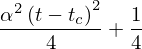

In [53]:
Eq_En_df_ideal.rhs.subs({n:0})

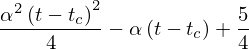

In [54]:
Eq_En_df_ideal.rhs.subs({n:1})

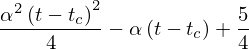

In [55]:
Eq_En_df_ideal.rhs.subs({n:1})

In [56]:
Eq_En_df_ideal.rhs.subs({n:0, t:tc + τB/2})

In [57]:
Eq_En_df_ideal.rhs.subs({n:1, t:tc + τB/2})

If we use the dynamic Hamiltonian for propagation, we can transform the resulting states $\ket{\Psi_{df}}$ back to the lab frame according to

In [58]:
U_RAP_dynamic = exp(I * sympy.Integral(defs[η(t)], t).doit())
Eq(
    symbols(r'\vert\Psi_{lab}\rangle'),
    U_RAP_dynamic.conjugate() * symbols(r'\vert\Psi_{df}\rangle'),
)

\vert\Psi_{lab}\rangle = \vert\Psi_{df}\rangle*exp(-I*(-alpha**2*t**3/12 + alpha**2*t**2*t_c/4 + t*(-alpha**2*t_c**2/4 - 1/4)))

In [59]:
En

E_n

## Rabi scheme

When using Rabi pulses, we consider a simple CW laser with a static frequency $\omega_L$. Consequently, the laser phase is

In [60]:
ωL = symbols('omega_L', positive=True)
pipulse_phase = {
    ϕ(t): (ωL * t),
}
Eq(ϕ(t), pipulse_phase[ϕ(t)])

phi(t) = omega_L*t

The energy levels then take the form (neglecting $\beta$ and $\Omega_\Delta(t)$)

In [61]:
En_wL = Eq_En.rhs.subs(pipulse_phase).subs({β: 0, ΩΔ(t): 0}).doit()
Eq(symbols("E_n^{(\\omega_L)}"), En_wL)

E_n^{(\omega_L)} = hbar*n**2*omega_k + hbar*n*omega_L

We choose a laser frequency that targets the transition $n_0 \rightarrow n_0+1$ ("up" direction). That is, we choose $\omega_L$ such that $E_{n_0}^{(\omega_L)}$ and $E_{n_0+1}^{(\omega_L)}$ are equal. 

In [62]:
n0 = symbols("n_0", integer=True)
defs[ωL] = sympy.solve(En_wL.subs({n: n0+1}) - En_wL.subs({n: n0}), ωL)[0]
definition(ωL)

omega_L = -omega_k*(2*n_0 + 1)

This can be plugged back into the laser phase:

In [63]:
pipulse_phase = {
    ϕ(t): (ωL * t).subs(definition(ωL).as_dict),  # changed sign (rot frame)
}
Eq(ϕ(t), pipulse_phase[ϕ(t)], tag='Rabi')

phi(t) = -omega_k*t*(2*n_0 + 1)    ('Rabi')

We can now write out the Schrödinger equation the determines the dynamics for a Rabi pulse starting from the transition $n_0$. It is usefule to introduce the *relative* momentum number:

In [64]:
nprime = symbols("n'", integer=True)
defs[nprime] = n - n0
definition(nprime)

n' = n - n_0

The Hamiltonian then reads:

In [65]:
def rewrite_with_nprime(abs_n=None):
    E_n = ((nprime**2 - nprime) - (n0 * (n0+1))) * protect(ħ*ωk)
    E_n_expanded = (
        E_n
        .subs(definition(nprime).as_dict)
        .expand()
        .doit() # un-protect ħωₖ
    )
    if abs_n is not None:
        E_n_expanded = E_n_expanded.subs({Abs(n): abs_n})
        
    def _doit(expr):
        return expr.subs({E_n_expanded: E_n})
    
    return _doit        

In [66]:
TDSE_pipulse = (
    TDSE_discrete_p0
    .apply(plug_in_phases(pipulse_phase))
    .apply(rewrite_with_nprime())
)
TDSE_pipulse

I*hbar*Derivative(a(n, t), t) = -hbar*Omega(t)*a(n - 1, t) - hbar*Omega(t)*a(n + 1, t) + a(n, t)*(beta**2*hbar*omega_k + 2*beta*hbar*n*omega_k - hbar*Omega_Delta(t) + (n'**2 - n' - n_0*(n_0 + 1))*(hbar*omega_k))

What are the energies for the Hamiltonian targeting the $n_0 \rightarrow n_0 + 1$ transition? We can make a table of energy levels surrounding $n_0$ for a given value of $n_0$, using the formula for the energy levels in units of $\hbar \omega_k$ and without initial velocity/common light shift.

In [67]:
Eq(symbols('E_n^{(n_0)}', cls=Function)(t), TDSE_pipulse.rhs.coeff(a(n, t)).subs({ΩΔ(t): 0, β: 0, ħ: 1, ωk: 1}).doit())

E_n^{(n_0)}(t) = n'**2 - n' - n_0*(n_0 + 1)

In [68]:
def tabulate_rabi_energy_levels(En, n0s, n_levels=2, subs=None):
    from IPython.display import Latex

    if subs is None:
        subs = {}
    n_cols = 2 * n_levels + 1  # excluding the first "index" column
    res = r'\begin{array}{l|' + "".join(['l' for _ in range(n_cols)]) + '}'
    res += "\n"
    col_labels = [
        "E_{n_0%+d}^{(n_0)}" % n for n in incl_range(-n_levels, n_levels)
    ]
    res += r'n_0 & ' + " & ".join(col_labels) + r'\\ \hline' + "\n"
    n_sym, n0_sym, nprime_sym = symbols("n, n_0, n'", integer=True)
    row_strs = []
    for n0 in n0s:
        col_strs = [str(n0)]
        En_n0 = En.subs({n0_sym: n0}).subs(subs)
        for n in incl_range(n0 - n_levels, n0 + n_levels):
            nprime = n - n0
            En_n0_n = En_n0.subs({n_sym: n, nprime_sym: nprime}).doit()
            col_strs.append(sympy.latex(En_n0_n))
        row_strs.append(" & ".join(col_strs))
    res += "\\\\\n".join(row_strs)
    res += r'\end{array}'
    return Latex(res)

In [69]:
tabulate_rabi_energy_levels(En=TDSE_pipulse.rhs.coeff(a(n, t)), n0s = incl_range(-2, 2), n_levels=3, subs={ΩΔ(t): 0, β: 0, ħ: 1, ωk: 1})

<IPython.core.display.Latex object>

We see that levels $n_0$ and $n_0+1$ have the same energy; the transition to the next level in either direction is detuned by $2 \hbar \omega_k$.

### Dynamic Frame

By choosing a suitable dynamic frame, we can eliminate the explicit dependence on $n_0$:

In [70]:
U_Rabi_dynamic = exp(-I * (n0 * (n0 + 1)) * ωk * t)

In [71]:
En_Rabi_dynamic_frame = (
    Eq(
        En(t),
        to_dynamic_frame(
            H=TDSE_pipulse.rhs.coeff(a(n, t)),
            U=U_Rabi_dynamic,
        ),
    )
    .apply_mtd('expand', cont=True)
)
En_Rabi_dynamic_frame

E_n(t) = beta**2*hbar*omega_k + 2*beta*hbar*n*omega_k + hbar*n_0*omega_k*(n_0 + 1) + hbar*omega_k*(n'**2 - n' - n_0*(n_0 + 1)) - hbar*Omega_Delta(t)
       = beta**2*hbar*omega_k + 2*beta*hbar*n*omega_k + hbar*n'**2*omega_k - hbar*n'*omega_k - hbar*Omega_Delta(t)

Again, we can tabulate the energy levels in units of $\hbar \omega_k$, and without the initial velocity velocity or the common light shift:

In [72]:
En_Rabi_dynamic_frame.apply_mtd('subs', {ΩΔ(t): 0, β: 0, ħ: 1, ωk: 1})

E_n(t) = n'**2 - n'

In [73]:
tabulate_rabi_energy_levels(En=En_Rabi_dynamic_frame.rhs, n0s = incl_range(-2, 2), n_levels=3, subs={ΩΔ(t): 0, β: 0, ħ: 1, ωk: 1})

<IPython.core.display.Latex object>

We see that the energy leves are indeed independent of $n_0$.

If we use the dynamic Hamiltonian for propagation, we can transform the resulting states $\ket{\Psi_{df}}$ back to the lab frame according to

In [74]:
Eq(
    symbols(r'\vert\Psi_{lab}\rangle'),
    U_Rabi_dynamic.conjugate() * symbols(r'\vert\Psi_{df}\rangle'),
)

\vert\Psi_{lab}\rangle = \vert\Psi_{df}\rangle*exp(I*n_0*omega_k*t*(n_0 + 1))